### What is Style Transfer?

Neural style transfer is an artificial system based on the Deep Neural Network which extracts the structural features from a content image and the style features from a style image to create a new artistic image.

#### Importing the libraries:

In [1]:
import pandas as pd 
import numpy as np

import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

#### Importing the content and style image:

In [11]:
content_path="C:\\Users\\hp\\Desktop\\Dashtoon assignment\\images\\content.jpg"
style_path ="C:\\Users\\hp\\Desktop\\Dashtoon assignment\\images\\style11.jpg"

#### Function to load the images and convert them into a numpy array:

In [12]:
def load_img(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0)
    return im_array

#### Function to plot the image from its numpy array:

In [13]:
def show_img(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

#### Plotting the input images:

In [14]:
content = load_img(content_path)
style = load_img(style_path)

C:\Users\hp\AppData\Local\Temp\ipykernel_2804\377996815.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


C:\Users\hp\AppData\Local\Temp\ipykernel_2804\377996815.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


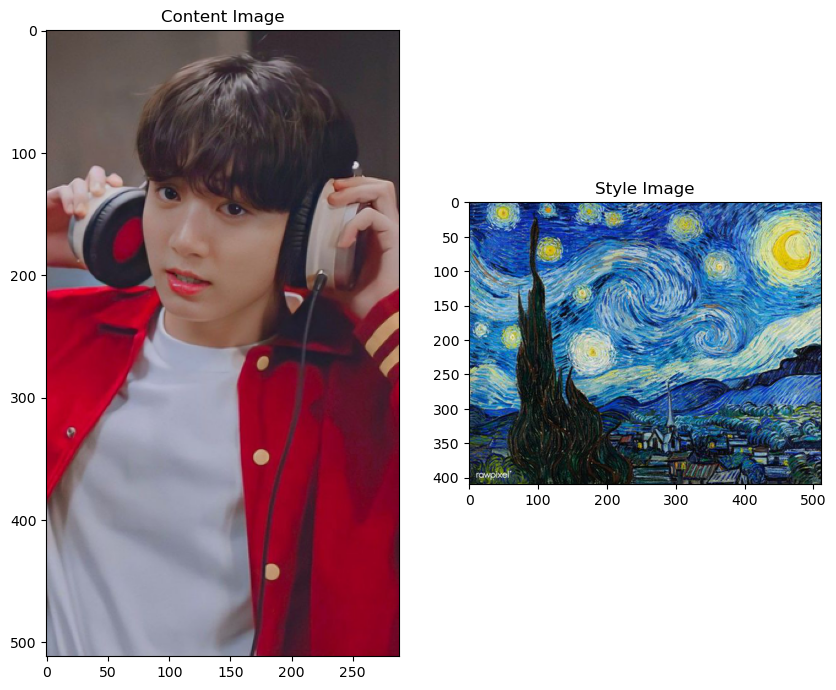

In [15]:
plt.figure(figsize=(10,10))
content = load_img(content_path)
style = load_img(style_path)
plt.subplot(1,2,1)
show_img(content,'Content Image')
plt.subplot(1,2,2)
show_img(style,'Style Image')
plt.show()

#### Function to convert the image into input for the CNN model:
We are using the VGG19 cnn model for Style Tranfer. It takes three image inputs: the content image, the style reference image and the placeholder that will contain the generated image. The style reference image and the content image are static, while the values in the placeholder will change over time. It trains on the image by normalizing its BGR channels by mean = [103.939, 116.779, 123.68]

In [16]:
def preprocess_img(img_path):
    image=load_img(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [17]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [18]:
im = preprocess_img(content_path)

C:\Users\hp\AppData\Local\Temp\ipykernel_2804\377996815.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


In [19]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

#### Defining the VGG19 CNN Model:

In [20]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

#### Model Architecture

In [21]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


#### Loss Function:

Two loss functions are defined in order to perform neural style transfer, to minimise the disparities between a content image, a style image, and a generated image. By minimising the content and style distances (losses) via backpropagation, the base input image is transformed into an image that matches the content of the content image and the style of the style image.

The content loss function makes sure that the generated image and the content image have similar higher layer activations. The style loss function ensures that the generated image and the style image have similar activation correlations in every layer.

#### 1. Defining the Content Loss Function
Content loss measures the root mean squared error between the activations that the content image and the generated image create.

In [22]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

#### 2. Defining the Style Loss Function
The generated image and the style image are to be used to create a style matrix. The root mean square difference between the two style matrices is then defined as the style loss. The correlation between feature maps in a given layer is used to measure style information. The difference in correlation between the feature maps, calculated by the generated image and the style image, is then defined as a loss. The correlation between a convolution layer's feature maps is determined using the gram matrix.

In [23]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [24]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [25]:
def get_features(model,content_path,style_path):
    content_img=preprocess_img(content_path)
    style_img=preprocess_img(style_path)
    
    content_output=model(content_img)
    style_output=model(style_img)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

#### Function to compute the total loss:

In [26]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

#### Function to calculate Gradient:

In [27]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [28]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = preprocess_img(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
         
        #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    return best_img,best_loss,imgs

#### Style Transfer Visualization:

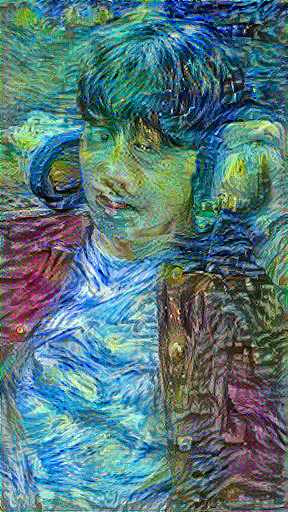

Epoch: 495
Total loss: 1.7442e+06, style loss: 6.1872e+05, content loss: 1.1255e+06, 


In [19]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)